In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from matplotlib.colors import ListedColormap

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import os
import pickle

import multiprocessing

home = "../../"
img_path = home + "Results/Images/2Classes/"
csv_path = home + "Results/Dataframes/2Classes/"

n_cores = multiprocessing.cpu_count() - 2
fig_width_pt = 222.62206                # Get this from LaTeX using \the\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inches
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height =fig_width*golden_mean       # height in inches
fig_size = [fig_width,fig_height]
params = {'backend': 'ps',
          'axes.labelsize': 10,
          'legend.fontsize': 10,
          'xtick.labelsize': 8,
          'ytick.labelsize': 8,
          'figure.figsize': fig_size}

mpl.rcParams.update(params)

In [2]:
names = ['ID', 'Xcor','Ycor', 'F606','eF606','F814','eF814','chi','sharp']
df_stars = pd.read_csv('../../Data/hlsp_deep47tuc_hst_acs_47tuc_f606w-f814w_v1_catalog.txt', 
                      names=names, delim_whitespace=True, skiprows=1)

df_stars['Color'] = df_stars.F606 - df_stars.F814

x = df_stars['Color'].to_numpy()
y = 16.5 + 4. * x

df_stars.loc[df_stars.F814 >= y, 'Label'] = 1
df_stars.loc[df_stars.F814 < y, 'Label'] = 0

df_stars.head()

,ID,Xcor,Ycor,F606,eF606,F814,eF814,chi,sharp,Color,Label
0,8,4462.947,140.859,28.197,0.1036,27.127,0.1068,6.106,0.7310,1.070,1.0
1,120,5002.486,186.138,20.843,0.0552,19.815,0.0661,10.690,0.4000,1.028,0.0
2,165,5003.574,195.421,27.014,0.2194,26.068,0.1349,10.651,0.1940,0.946,1.0
3,226,4448.493,207.417,30.193,0.3641,28.270,0.1636,4.059,-1.9585,1.923,1.0
4,351,5040.717,224.366,28.935,0.1669,28.941,0.2464,4.274,-0.7720,-0.006,1.0


# Visualize Data

(33.0, 12.0)

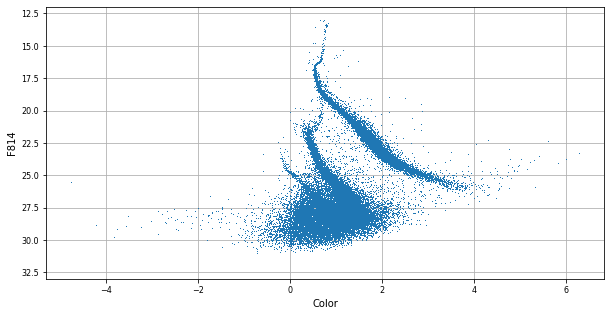

In [3]:
plt.figure(figsize=(10,5))
plt.plot(df_stars.Color, df_stars.F814, ',')
plt.xlabel('Color')
plt.ylabel('F814')
plt.grid()
#plt.xlim(33, 13)
plt.ylim(33, 12)

# Splitting the dataset into train and test samples 

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import minmax_scale

x_preprocessed = minmax_scale(X=df_stars.drop(labels=['Label'], axis=1).values)
x_train, x_test, y_train, y_test = train_test_split(x_preprocessed, df_stars.Label.values)

# Grid Search and Cross Validation process
## Random Forest Classifier and Grid Search

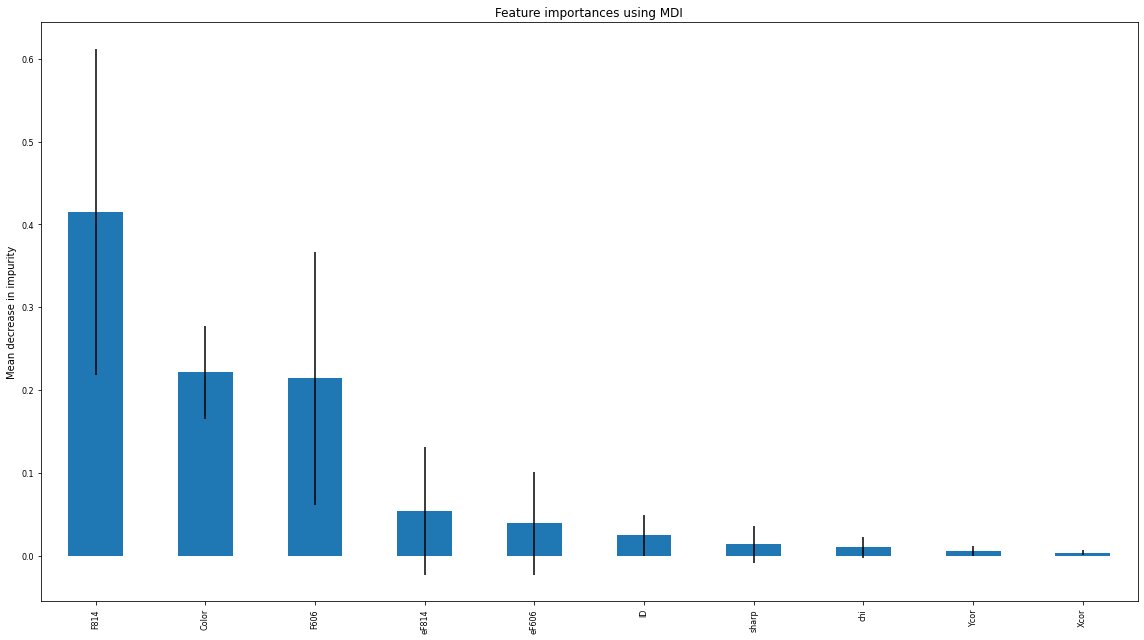

In [5]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import ExtraTreesClassifier

path = home + "Model_best_parameters/2Classes/"
file = "best_parameters_DT.p"

if not(os.path.isfile(path + file)):
    grid_param_DT = {'n_estimators': [100, 300, 500, 800, 1000],
                     'criterion': ['gini', 'entropy']
                    }

    model_DT = ExtraTreesClassifier()

    gs_src_DT = GridSearchCV(estimator=model_DT, 
                 param_grid=grid_param_DT,
                 scoring='accuracy',
                 cv=10,
                 n_jobs=-1)

    gs_src_DT.fit(x_train, y_train)
    
    best_parameters = gs_src_DT.best_params_
    pickle.dump(best_parameters, open(path + file, "wb"))
    
    model_DT = ExtraTreesClassifier(**best_parameters)
    model_DT.fit(X=x_train, y=y_train)
    
    importances = model_DT.feature_importances_
    std = np.std([tree.feature_importances_ for tree in model_DT.estimators_], axis=0)

    forest_importances = pd.Series(importances, index=df_stars.drop(labels=['Label'], 
                                                                    axis=1).columns)

    fig, ax = plt.subplots(figsize=(16,9))
    forest_importances.plot.bar(yerr=std, ax=ax)
    ax.set_title("Feature importances using MDI")
    ax.set_ylabel("Mean decrease in impurity")
    fig.tight_layout()
else:
    DT_param = pickle.load(open(path + file, 'rb'))
    
    model_DT = ExtraTreesClassifier(**DT_param)
    model_DT.fit(X=x_train, y=y_train)

    std = np.std([tree.feature_importances_ for tree in model_DT.estimators_], axis=0)

    forest_importances = pd.DataFrame({'Importances': model_DT.feature_importances_, 
                                       'Std': std}, index=df_stars.drop(labels=['Label'], 
                                                                    axis=1).columns)

    forest_importances.sort_values(by='Importances', ascending=False, inplace=True)

    fig, ax = plt.subplots(figsize=(16,9))
    forest_importances.Importances.plot.bar(yerr=forest_importances.Std, ax=ax)
    ax.set_title("Feature importances using MDI")
    ax.set_ylabel("Mean decrease in impurity")
    fig.tight_layout()

In [6]:
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score


scoring = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score, average='micro'),
           'recall' : make_scorer(recall_score, average='micro'), 
           'f1_score' : make_scorer(f1_score, average='micro')}

model_DT = ExtraTreesClassifier(**DT_param)

DT_score = cross_validate(estimator=model_DT, X=x_train, y=y_train, cv=n_cores, scoring=scoring, n_jobs=n_cores)

## Support Vector Classifier Grid Search

In [7]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

file = "best_parameters_svm.p"

if not(os.path.isfile(path + file)):
    grid_param_SVM = {'C': [0.1, 1, 10, 100],
                      'kernel': ['poly', 'rbf']
                     }

    model_SVM = SVC(class_weight='balanced')


    gs_src_svm = GridSearchCV(estimator=model_SVM, 
                 param_grid=grid_param_SVM,
                 scoring='accuracy',
                 cv=10,
                 n_jobs=-1)

    gs_src_svm.fit(x_train, y_train)
    
    SVM_param = gs_src_svm.best_params_
    SVM_param
    
    pickle.dump(SVM_param, open(path + file, "wb"))
else: 
    SVM_param = pickle.load(open(path + file, "rb"))

In [8]:
model_SVM = SVC(**SVM_param, class_weight='balanced')

SVM_score = cross_validate(estimator=model_SVM, X=x_train, y=y_train, cv=n_cores, scoring=scoring, n_jobs=n_cores)

In [ ]:
file = ""
#pd.DataFrame(SVM_score).T.mean(axis=1), pd.DataFrame(SVM_score).T.std(axis=1)

In [34]:
mean = pd.DataFrame(SVM_score).T.mean(axis=1).to_frame(name='mean')
mean.columns
std = pd.DataFrame(SVM_score).T.std(axis=1).to_frame(name='std')
mean.join(std)

,mean,std
fit_time,0.810185,0.046176
score_time,0.020619,0.004652
test_accuracy,0.999223,0.000473
test_precision,0.999223,0.000473
test_recall,0.999223,0.000473
test_f1_score,0.999223,0.000473


In [20]:
file = "SVM_score.csv"
if not(os.path.isfile(path + file)):
    pd.DataFrame(SVM_score).T.iloc[2:].to_csv(csv_path + file, header=False)

file = "SVM_mean_score.csv"
if not(os.path.isfile(path + file)):
    mean = pd.DataFrame(SVM_score).T.mean(axis=1)
    std = pd.DataFrame(SVM_score).T.std(axis=1)
    pass

In [ ]:
#pd.DataFrame(SVM_score).T.mean(axis=1), pd.DataFrame(SVM_score).T.std(axis=1)

In [ ]:
#pd.DataFrame(SVM_score).T.to_csv("../Results/SVM_score.csv", header=False)

## New investigations

### Random Forest 

In [ ]:
model_DT.fit(x_train, y_train)

DT_train_pred = model_DT.predict(X=x_train)
DT_test_pred = model_DT.predict(X=x_test)

Train report:

              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00     21210
         0.0       1.00      1.00      1.00     17400

    accuracy                           1.00     38610
   macro avg       1.00      1.00      1.00     38610
weighted avg       1.00      1.00      1.00     38610

Test report:

              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00      7067
         0.0       1.00      1.00      1.00      5803

    accuracy                           1.00     12870
   macro avg       1.00      1.00      1.00     12870
weighted avg       1.00      1.00      1.00     12870



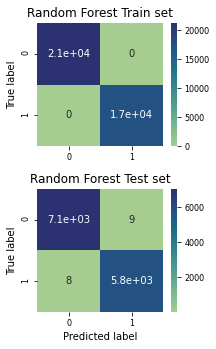

In [ ]:
print('Train report:\n')

labels = df_stars.Label.unique()

print(classification_report(y_train, DT_train_pred, labels=labels))

fig, axs = plt.subplots(2, 1, figsize=(fig_width, fig_width*golden_mean*2.6))
sns.heatmap(confusion_matrix(y_train, DT_train_pred, labels=labels), 
            ax=axs[0], cmap="crest", annot=True)
axs[0].set_title('Random Forest Train set')
axs[0].set_ylabel('True label')

print('Test report:\n')
print(classification_report(y_test, DT_test_pred, labels=labels))

sns.heatmap(confusion_matrix(y_test, DT_test_pred, labels=labels), 
            ax=axs[1], cmap="crest", annot=True)
axs[1].set_title('Random Forest Test set')
axs[1].set_ylabel('True label')
axs[1].set_xlabel('Predicted label')

fig.tight_layout()

#plt.savefig('../Results/Images/DT_confusion_matrix.png', dpi=2000, transparent=False)

### SVM 

In [ ]:
model_SVM.fit(X=x_train, y=y_train)

SVM_train_pred = model_SVM.predict(X=x_train)
SVM_test_pred = model_SVM.predict(X=x_test)

Train report:

              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00     21210
         0.0       1.00      1.00      1.00     17400

    accuracy                           1.00     38610
   macro avg       1.00      1.00      1.00     38610
weighted avg       1.00      1.00      1.00     38610

Test report:

              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00      7067
         0.0       1.00      1.00      1.00      5803

    accuracy                           1.00     12870
   macro avg       1.00      1.00      1.00     12870
weighted avg       1.00      1.00      1.00     12870



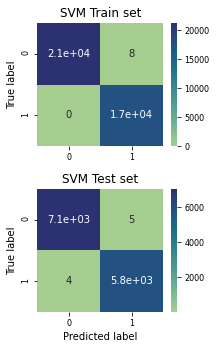

In [ ]:
print('Train report:\n')
print(classification_report(y_train, SVM_train_pred, labels=labels))

fig, axs = plt.subplots(2, 1, figsize=(fig_width, fig_width*golden_mean*2.6))
sns.heatmap(confusion_matrix(y_train, SVM_train_pred, labels=labels), 
            ax=axs[0], cmap="crest", annot=True)
axs[0].set_title('SVM Train set')
axs[0].set_ylabel('True label')

sns.heatmap(confusion_matrix(y_test, SVM_test_pred, labels=labels), 
            ax=axs[1], cmap="crest", annot=True)
axs[1].set_title('SVM Test set')
axs[1].set_ylabel('True label')
axs[1].set_xlabel('Predicted label')
fig.tight_layout()
print('Test report:\n')
print(classification_report(y_test, SVM_test_pred, labels=labels))

#plt.savefig('../Results/Images/SVM_confusion_matrix.png', dpi=2000, transparent=False)

In [ ]:
print(classification_report(y_test, SVM_test_pred, labels=labels))
confusion_matrix(y_test, SVM_test_pred, labels=labels)

              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00      7067
         0.0       1.00      1.00      1.00      5803

    accuracy                           1.00     12870
   macro avg       1.00      1.00      1.00     12870
weighted avg       1.00      1.00      1.00     12870



array([[7062,    5],
       [   4, 5799]], dtype=int64)